In [1]:
pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import gc

# Function to optimize memory usage
def optimize_memory(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Load a CSV file from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/NapQueen/forecasting-unit-sales-vit-task-2/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/NapQueen/forecasting-unit-sales-vit-task-2/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Optimize memory usage
train_data = optimize_memory(train_data)
test_data = optimize_memory(test_data)

In [5]:
# Convert 'date' to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [6]:
# Check for missing values
print(train_data.isnull().sum())
print(test_data.isnull().sum())

ID                0
date              0
Item Id           2
Item Name      1832
ad_spend      24187
anarix_id         0
units         17898
unit_price        0
dtype: int64
ID               0
date             0
Item Id          0
Item Name      344
ad_spend      1451
anarix_id        0
unit_price       0
dtype: int64


In [7]:
# Drop rows where 'Item Id' is missing
train_data = train_data.dropna(subset=['Item Id'])

# Drop columns with excessive missing values (e.g., more than 50% missing values)
train_data = train_data.drop(columns=['Item Name'])
test_data = test_data.drop(columns=['Item Name'])

In [8]:
#Impute 'ad_spend' with median value
median_ad_spend = train_data['ad_spend'].median()
train_data['ad_spend'].fillna(median_ad_spend, inplace=True)
test_data['ad_spend'].fillna(median_ad_spend, inplace=True)

# Impute 'units' with median value
median_units = train_data['units'].median()
train_data['units'].fillna(median_units, inplace=True)

<ipython-input-8-469446b570ca>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.23' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  test_data['ad_spend'].fillna(median_ad_spend, inplace=True)


In [9]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

ID            0
date          0
Item Id       0
ad_spend      0
anarix_id     0
units         0
unit_price    0
dtype: int64
ID            0
date          0
Item Id       0
ad_spend      0
anarix_id     0
unit_price    0
dtype: int64


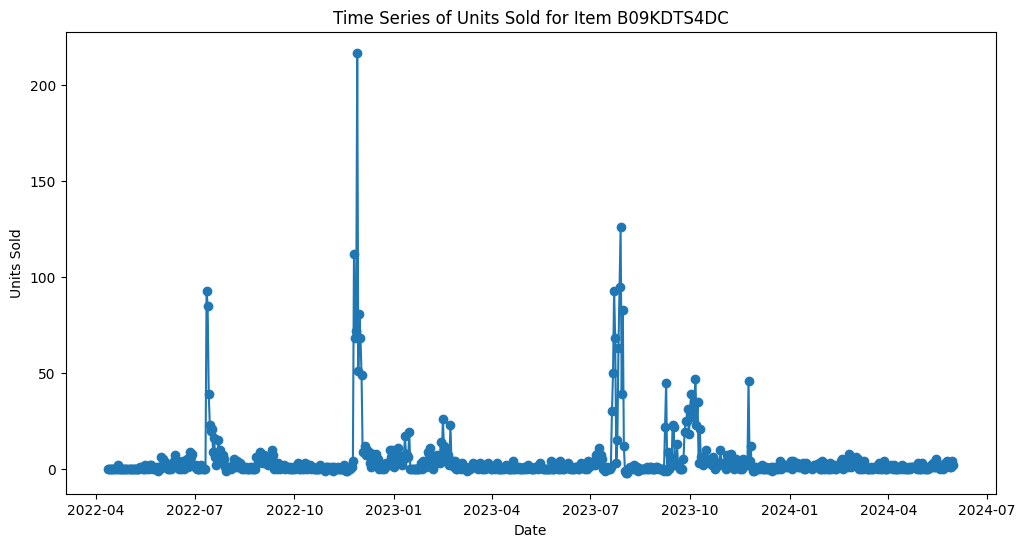

In [10]:
#TIME SERIES PLOT
# Plot sales trends over time for a sample item
sample_item = train_data['Item Id'].unique()[0]
sample_data = train_data[train_data['Item Id'] == sample_item]

plt.figure(figsize=(12, 6))
plt.plot(sample_data['date'], sample_data['units'], marker='o')
plt.title(f'Time Series of Units Sold for Item {sample_item}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()


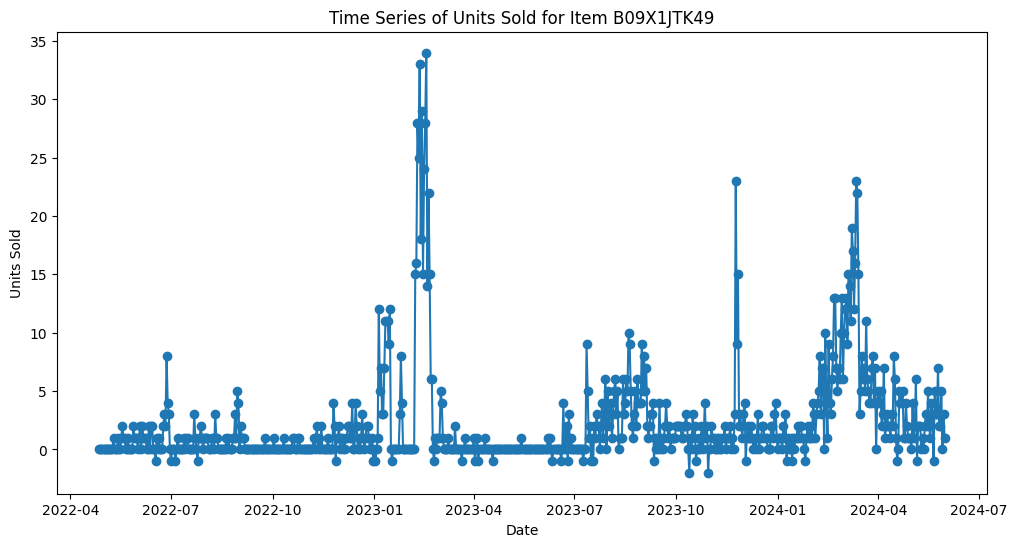

In [11]:
sample_item = train_data['Item Id'].unique()[30]
sample_data = train_data[train_data['Item Id'] == sample_item]

plt.figure(figsize=(12, 6))
plt.plot(sample_data['date'], sample_data['units'], marker='o')
plt.title(f'Time Series of Units Sold for Item {sample_item}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

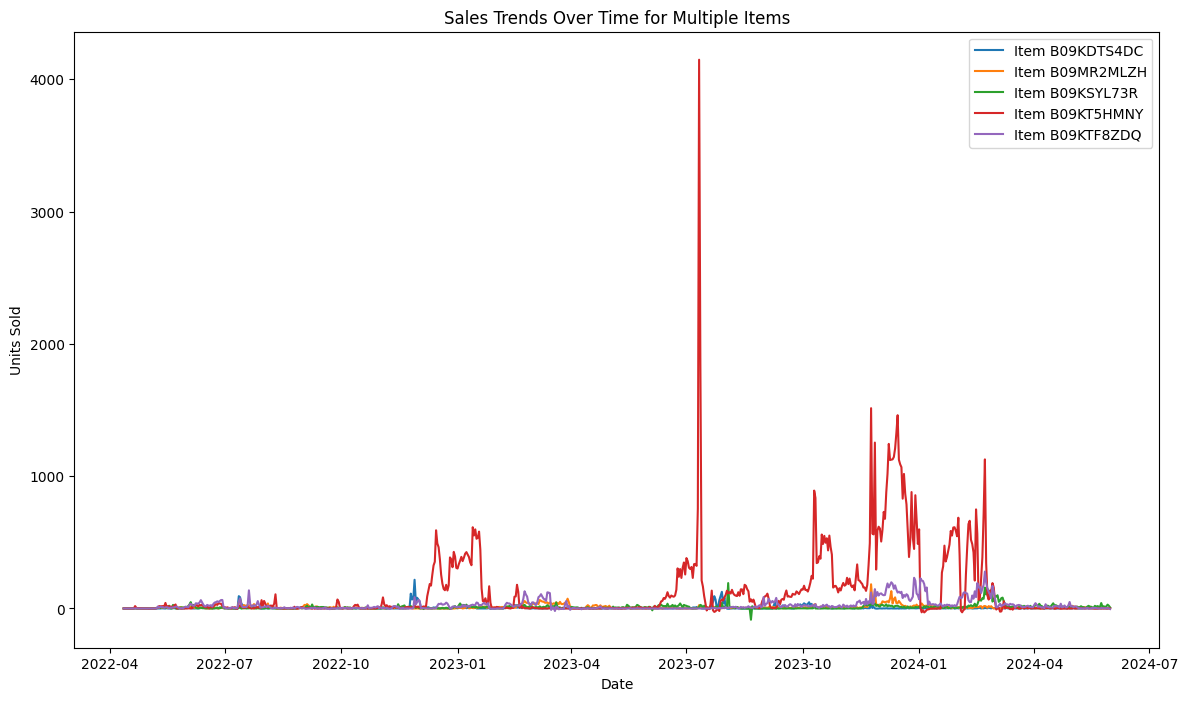

In [12]:
# Plot time series for multiple items
plt.figure(figsize=(14, 8))
for item_id in train_data['Item Id'].unique()[:5]:  # Plot for first 5 items for clarity
    item_data = train_data[train_data['Item Id'] == item_id]
    plt.plot(item_data['date'], item_data['units'], label=f'Item {item_id}')

plt.title('Sales Trends Over Time for Multiple Items')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

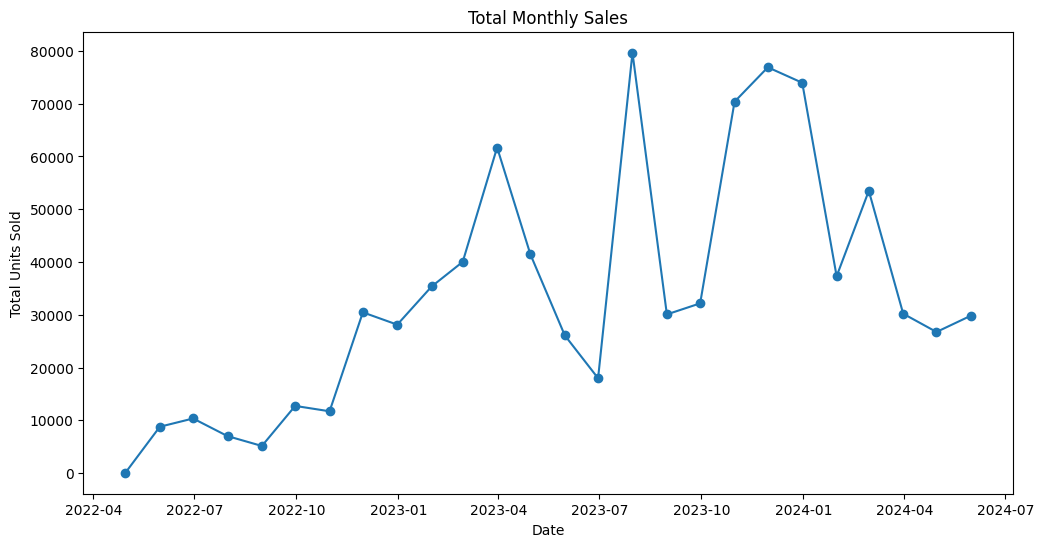

In [13]:
#MONTHLY SALES AGGREGATION
# Aggregate sales data by month
monthly_sales = train_data.resample('M', on='date').agg({'units': 'sum'})

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['units'], marker='o', linestyle='-')
plt.title('Total Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.show()

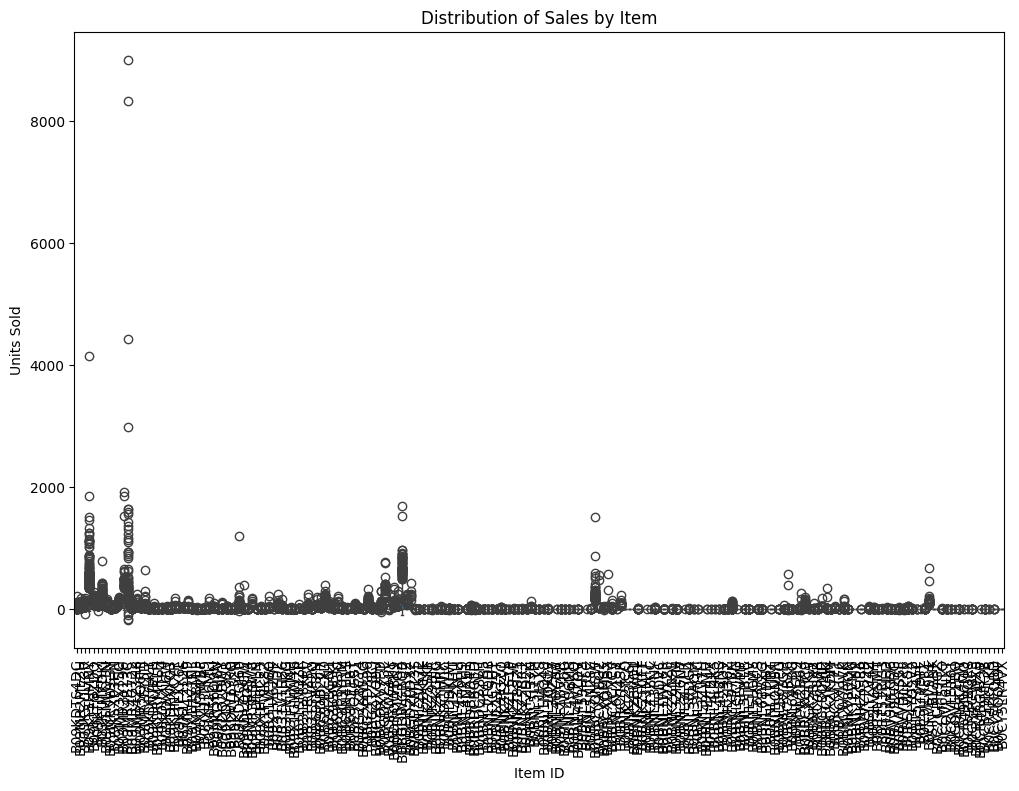

In [14]:
# SALES DISTRIBUTION
plt.figure(figsize=(12, 8))
sns.boxplot(x='Item Id', y='units', data=train_data)
plt.title('Distribution of Sales by Item')
plt.xlabel('Item ID')
plt.ylabel('Units Sold')
plt.xticks(rotation=90)
plt.show()

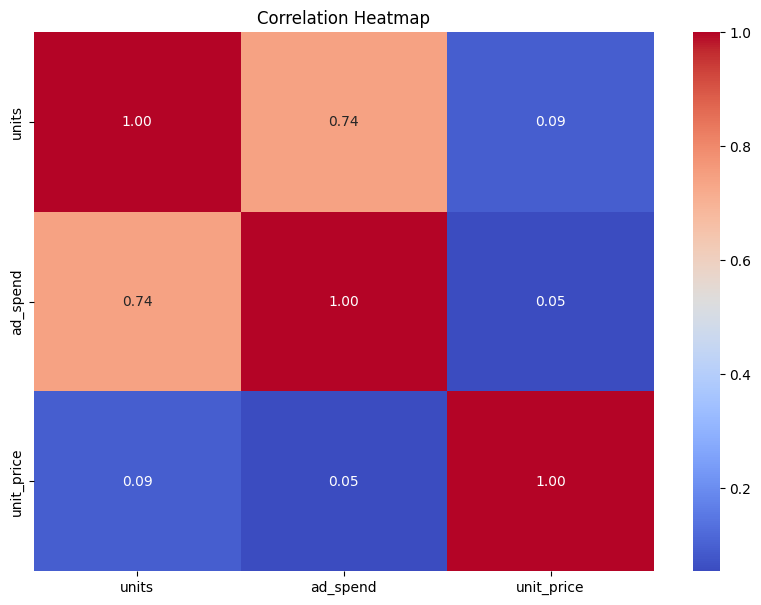

In [15]:
# CORREALTION HEATMAP
correlation_matrix = train_data[['units', 'ad_spend', 'unit_price']].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


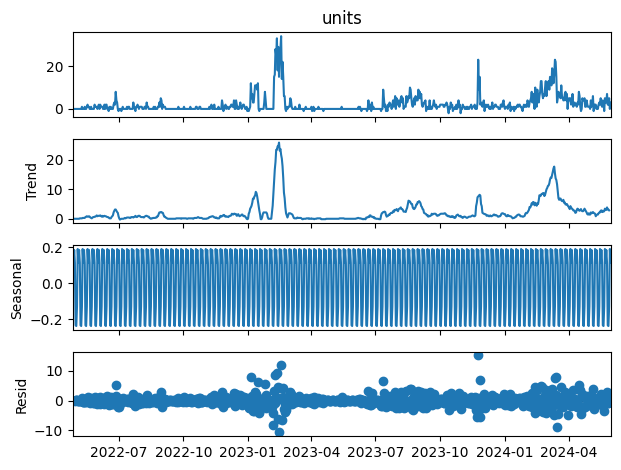

In [16]:
# SEASONAL DECOMPOSITION
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(sample_data.set_index('date')['units'], model='additive')
decomposition.plot()
plt.show()

In [17]:
#Create Time-Based Features
# Extract time-based features
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['dayofweek'] = train_data['date'].dt.dayofweek
train_data['is_weekend'] = (train_data['dayofweek'] >= 5).astype(int)

test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['dayofweek'] = test_data['date'].dt.dayofweek
test_data['is_weekend'] = (test_data['dayofweek'] >= 5).astype(int)

In [18]:
# Inspect data
print(train_data.info())
print(train_data.head())
print(train_data.describe())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 101488 entries, 0 to 101489
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ID          101488 non-null  object        
 1   date        101488 non-null  datetime64[ns]
 2   Item Id     101488 non-null  object        
 3   ad_spend    101488 non-null  float64       
 4   anarix_id   101488 non-null  object        
 5   units       101488 non-null  float32       
 6   unit_price  101488 non-null  float64       
 7   year        101488 non-null  int32         
 8   month       101488 non-null  int32         
 9   day         101488 non-null  int32         
 10  dayofweek   101488 non-null  int32         
 11  is_weekend  101488 non-null  int64         
dtypes: datetime64[ns](1), float32(1), float64(2), int32(4), int64(1), object(3)
memory usage: 8.1+ MB
None
                      ID       date     Item Id  ad_spend anarix_id  units  \
0  2022-04-12_B09KDTS4

In [19]:
# Convert 'date' to datetime to run the model
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [20]:
# Prepare the data for Prophet
train_data_prophet = train_data[['date', 'units']].rename(columns={'date': 'ds', 'units': 'y'})

In [21]:
# Train/validation split
train_test_split = int(len(train_data_prophet) * 0.8)
train_prophet = train_data_prophet[:train_test_split]
val_prophet = train_data_prophet[train_test_split:]

In [22]:
# Fit the Prophet model
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f9iy9u3/m4cqjjgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f9iy9u3/m33c4_gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80092', 'data', 'file=/tmp/tmp2f9iy9u3/m4cqjjgk.json', 'init=/tmp/tmp2f9iy9u3/m33c4_gl.json', 'output', 'file=/tmp/tmp2f9iy9u3/prophet_modeluh3tny9t/prophet_model-20240802120155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
# Make predictions
future = model.make_future_dataframe(periods=len(val_prophet), freq='D')
forecast = model.predict(future)

In [24]:
# Evaluate the model on validation set
val_forecast = forecast[-len(val_prophet):]['yhat']
mse = mean_squared_error(val_prophet['y'], val_forecast)
print(f'Mean Squared Error on validation set: {mse}')

# Calculate RMSE for better interpretability
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on validation set: {rmse}')

Mean Squared Error on validation set: 143776.08711872145
Root Mean Squared Error on validation set: 379.17817331529176


In [25]:
# Forecast future values
future_test = model.make_future_dataframe(periods=len(test_data), freq='D', include_history=True)
forecast_test = model.predict(future_test)

# Extract only the forecasted values for the test period
forecast_future = forecast_test[-len(test_data):]

In [26]:
# Prepare submission
submission = pd.DataFrame({
    'date': test_data['date'],
    'Item Id': test_data['Item Id'],
    'TARGET': forecast_future['yhat'].values
})

In [27]:
# Save submission to CSV
submission.to_csv('submission.csv', index=False)

In [28]:
# Clear memory
del train_data, test_data
gc.collect()

0